In [6]:
%matplotlib inline
import copy, datetime, os, re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from scipy import stats

import SimpleITK as sitk
import data

if not os.path.isdir('figures'):
    os.mkdir('figures')

df_path = 'results/df_gpu'
ants_path = 'results/ants'

In [7]:
pairs = data.get_pairs()

def read_img(f):
    img = sitk.ReadImage(f)
    return sitk.GetArrayFromImage(img)

def read_t1(i):
    return read_img(data.image_file(i))

def read_segm(i):
    return read_img(data.segmentation_file(i))

def read_df_t1(p):
    return read_img(os.path.join(df_path, '{}_{}_t1.vtk'.format(p[0], p[1])))

def read_df_segm(p):
    return read_img(os.path.join(df_path, '{}_{}_segm.vtk'.format(p[0], p[1])))

def read_ants_t1(p):
    return read_img(os.path.join(ants_path, '{}_{}_t1.nii.gz'.format(p[0], p[1])))

def read_ants_segm(p):
    return read_img(os.path.join(ants_path, '{}_{}_segm.vtk'.format(p[0], p[1])))


def relabel_segm(img, labels):
    out = np.zeros(img.shape, dtype=np.uint8)
    i = 1
    for l in labels:
        mask = np.isin(img, l)
        out = out + i*mask
        i += 1
    
    return out.astype(np.uint8)


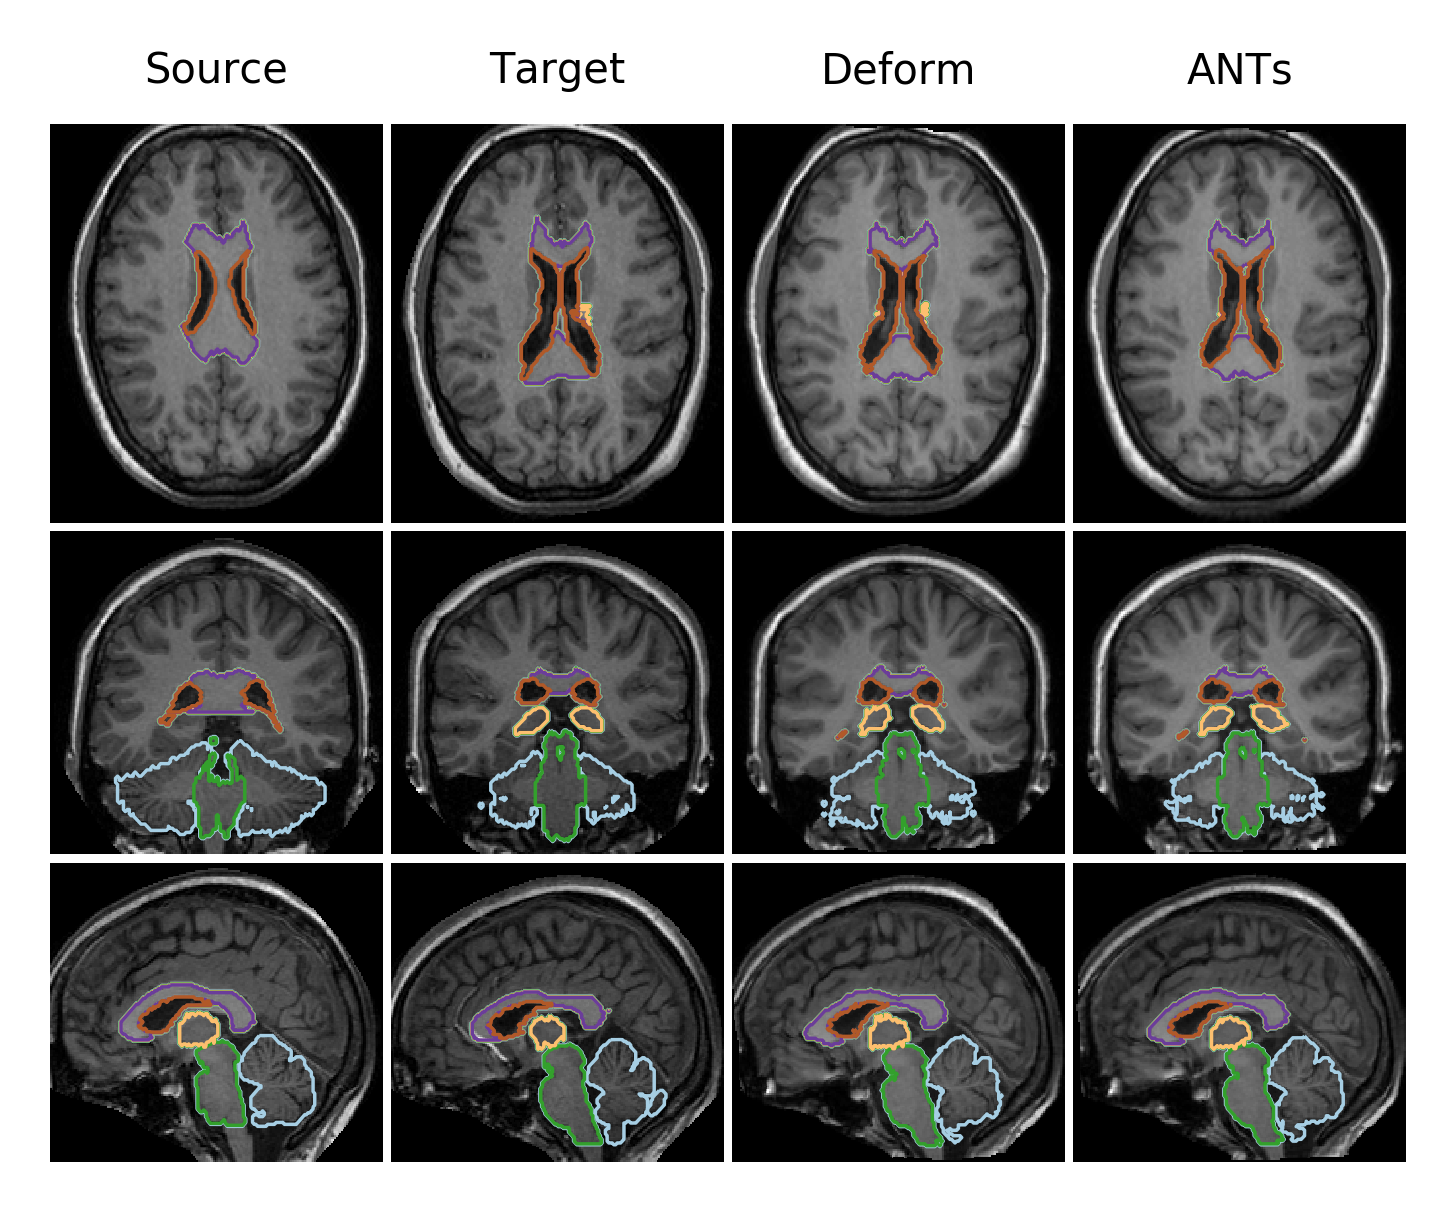

In [8]:
def do_plot(imgs, labels=None, cmap='Set1', figsize=(15, 15), column_titles=[], height_ratios=None):
    n_rows = len(imgs)
    n_cols = len(imgs[0])

    def normalize(img):
        return np.clip(255*img / np.max(img), 0, 255).astype(np.uint8)
    
    levels = None
    if labels:
        levels = range(0, len(labels))
    
    if height_ratios:
        gridspec_kw = {'height_ratios': height_ratios}
    else:
        gridspec_kw = None
        
    f, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=500, facecolor='white', gridspec_kw = gridspec_kw)

    for i in range(n_rows):
        for j in range(n_cols):
            idx = imgs[i][j][2]
            t1 = normalize(imgs[i][j][0])[idx]
            segm = imgs[i][j][1][idx]
            if labels:
                segm = relabel_segm(segm, labels)

            ax = axes[i,j]#plt.subplot(n_rows, n_cols, j+n_cols*i+1)
            ax.imshow(t1, cmap='gray', aspect="auto")
            #plt.imshow(segm, cmap='Set1')
            ax.contour(segm, linewidths=0.5, cmap=cmap, levels=levels)
            ax.axis('off')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            
    for i, c in enumerate(column_titles):
        axes[0,i].set_title(c, fontsize=6)
    
    plt.margins(0,0)
    #plt.tight_layout()   
    plt.subplots_adjust(wspace=0.025, hspace=0.025)

labels = [
    #(3, 4), # Amygdala
    (17, 18), # Cerebellum
    (19), # Brainstem
    #(24, 25), # Post. cingulate gyrus
    #(26, 27), # Post. cingulate gyrus
    #(34, 35), # Caudate nucleus
    #(38, 39), # Putamen (Not visible)
    (40, 41), # Thalamus
    #(42, 43), # Pallidum (Not visible)
    (44), # Corpus callosum
    (45, 46), # Lateral ventricle excl. temporal horn 
    #(76, 77), # Subgenual frontal cortex
    #(78, 79) # Subcallosal area
    
]

cmap = 'Paired'

p = ('a09', 'a15')

t1 = [read_t1(p[1]), read_t1(p[0]), read_df_t1(p), read_ants_t1(p)]
segm = [read_segm(p[1]), read_segm(p[0]), read_df_segm(p), read_ants_segm(p)]

do_plot(
    [
        [
            (t1[0], segm[0], np.s_[85,::-1]),
            (t1[1], segm[1], np.s_[85,::-1]),
            (t1[2], segm[2], np.s_[85,::-1]),
            (t1[3], segm[3], np.s_[85,::-1]),
        ],
        [
            (t1[0], segm[0], np.s_[::-1,85]),
            (t1[1], segm[1], np.s_[::-1,85]),
            (t1[2], segm[2], np.s_[::-1,85]),
            (t1[3], segm[3], np.s_[::-1,85]),
        ],
        [
            (t1[0], segm[0], np.s_[::-1,::-1,85]),
            (t1[1], segm[1], np.s_[::-1,::-1,85]),
            (t1[2], segm[2], np.s_[::-1,::-1,85]),
            (t1[3], segm[3], np.s_[::-1,::-1,85]),
        ]
    ],
    column_titles = ['Source', 'Target', 'Deform', 'ANTs'],
    height_ratios = [1, 0.81, 0.75],
    labels=labels, cmap=cmap, figsize=(3.5, 2.75)
)
plt.savefig('figures/{}_{}_vis.png'.format(*p), bbox_inches='tight', pad_inches = 0)